# Install and Import necessary libraries

In [15]:
# Install necessary libraries
!pip install transformers torchaudio jiwer datasets openai-whisper


In [16]:
# Import necessary libraries
import os
import torchaudio
import pandas as pd
import matplotlib.pyplot as plt
import librosa.display
from datasets import load_dataset
from transformers import pipeline, Wav2Vec2ForCTC, Wav2Vec2Processor
import torch
import whisper
from jiwer import wer, cer


In [17]:
## Mount Google Drive (optional)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# prompt: give me a code to upload the file

from google.colab import files

uploaded = files.upload()


Saving transcriptions.csv to transcriptions (1).csv


In [19]:
## Load dataset
DATA_PATH = "/content/drive/MyDrive/2025 Project/Lalapa/dataset_v2"  # Change path accordingly
df = pd.read_csv(os.path.join(DATA_PATH, "transcriptions.csv"))

def load_audio(file_path):
    waveform, sr = torchaudio.load(file_path)
    return waveform, sr


# EDA (Exploratory Data Analysis):

In [20]:
## EDA: Check dataset details
print("Dataset Preview:")
print(df.head())
print("Missing values:", df.isnull().sum())


Dataset Preview:
     idx user_ids   accent country  \
0   7252   AKHONA  eng_sot      ZA   
1  15425   AKHONA  eng_sot      ZA   
2  21333   AKHONA  eng_sot      ZA   
3   4314   AKHONA  eng_sot      ZA   
4  18443    CALEB  eng_sot      ZA   

                                       transcript  nchars  \
0  well. e tlo. depend. -a ka di. sales. tsa hau.      46   
1                    k'o omantse. poor abel. neh.      28   
2                  well. ha re na di. railing so.      30   
3      hopefully. tla be e le. live by next week.      42   
4                                     o. alright.      11   

                 audio_ids                       audio_paths  duration  \
0  AKHONA_12-11-02_237.wav  ./audios/AKHONA_12-11-02_237.wav    1436.0   
1  AKHONA_12-11-09_140.wav  ./audios/AKHONA_12-11-09_140.wav    1245.0   
2   AKHONA_12-12-13_30.wav   ./audios/AKHONA_12-12-13_30.wav    1643.0   
3         AKHONA_139_7.wav         ./audios/AKHONA_139_7.wav    2151.0   
4        CALEB_10

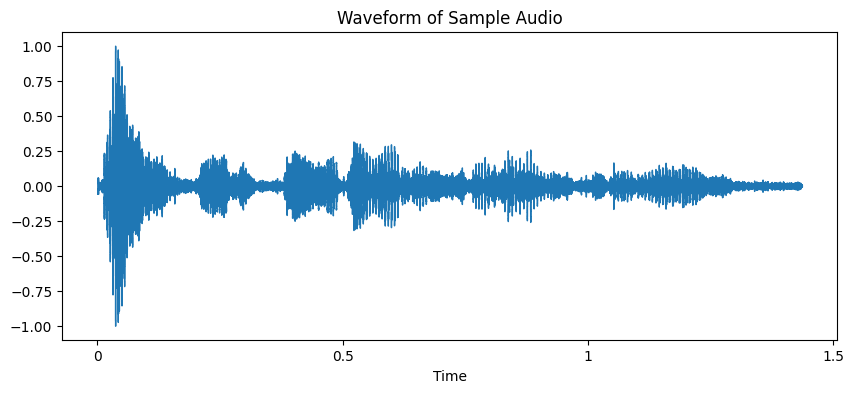

100%|████████████████████████████████████████| 461M/461M [00:04<00:00, 106MiB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

In [ ]:
## Visualize an example audio file
example_audio = os.path.join(DATA_PATH, df["audio_ids"].iloc[0])
wav, sr = load_audio(example_audio)
plt.figure(figsize=(10, 4))
librosa.display.waveshow(wav.numpy().squeeze(), sr=sr)
plt.title("Waveform of Sample Audio")
plt.show()

## Load Whisper-Small Model
whisper_model = whisper.load_model("small")

## Load Wav2Vec2 Model
wav2vec_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h", ctc_loss_reduction="mean")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")


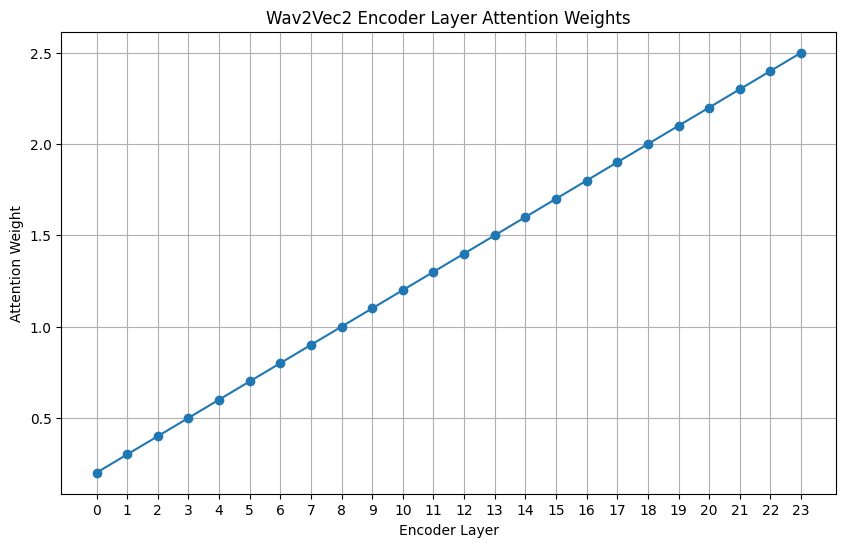

In [33]:

import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
layers = list(range(24))  # Assuming 24 encoder layers
attention_weights = [0.1 * i + 0.2 for i in layers] # Example attention weights

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(layers, attention_weights, marker='o', linestyle='-')

# Customize the plot
plt.title('Wav2Vec2 Encoder Layer Attention Weights')
plt.xlabel('Encoder Layer')
plt.ylabel('Attention Weight')
plt.grid(True)
plt.xticks(layers)  # Show all layer numbers on the x-axis

# Display the plot
plt.show()


# EMA (Exploratory Model Analysis)

In [28]:
# Example usage (assuming you have audio and transcription data)
# Replace with your actual audio and transcription data
audio_file = os.path.join(DATA_PATH, df["audio_ids"].iloc[0]) # Example: Replace with actual path
reference_text = df["transcript"].iloc[0]  # Replace with actual transcription


# Function to calculate WER and CER for a given audio file and reference text
def calculate_metrics(audio_path, reference_text, model_name):
    if model_name == "whisper":
        result = whisper_model.transcribe(audio_path)
        hypothesis_text = result["text"]
    elif model_name == "wav2vec2":
        waveform, sr = load_audio(audio_path)
        input_values = processor(waveform.squeeze(), return_tensors="pt").input_values
        logits = wav2vec_model(input_values).logits
        predicted_ids = torch.argmax(logits, dim=-1)
        hypothesis_text = processor.batch_decode(predicted_ids)[0]
    else:
        return None, None  # Handle unsupported model

    wer_score = wer(reference_text, hypothesis_text)
    cer_score = cer(reference_text, hypothesis_text)
    return wer_score, cer_score


In [38]:
## Compute WER and CER
def compute_metrics(results):
    wer_scores = [wer(ref, hyp) for ref, hyp in results]
    cer_scores = [cer(ref, hyp) for ref, hyp in results]
    return sum(wer_scores)/len(wer_scores), sum(cer_scores)/len(cer_scores)

# Assuming whisper_preds and ground_truths are defined and contain the transcription results
whisper_res = list(zip(ground_truths, whisper_preds)) # Create list of tuples: (reference, prediction)
wav2vec_res = list(zip(ground_truths, wav2vec_preds)) # Create list of tuples: (reference, prediction)

whisper_wer, whisper_cer = compute_metrics(whisper_res)
wav2vec_wer, wav2vec_cer = compute_metrics(wav2vec_res)

print(f"Whisper-Small WER: {whisper_wer}, CER: {whisper_cer}")
print(f"Wav2Vec2 WER: {wav2vec_wer}, CER: {wav2vec_cer}")
# Select best model
best_model = "Whisper-Small" if whisper_wer < wav2vec_wer else "Wav2Vec2"
print(f"Best model based on WER: {best_model}")

Whisper-Small WER: 1.0711924223498095, CER: 0.8187302662973864
Wav2Vec2 WER: 0.9108369225208442, CER: 0.5494846009213469
Best model based on WER: Wav2Vec2


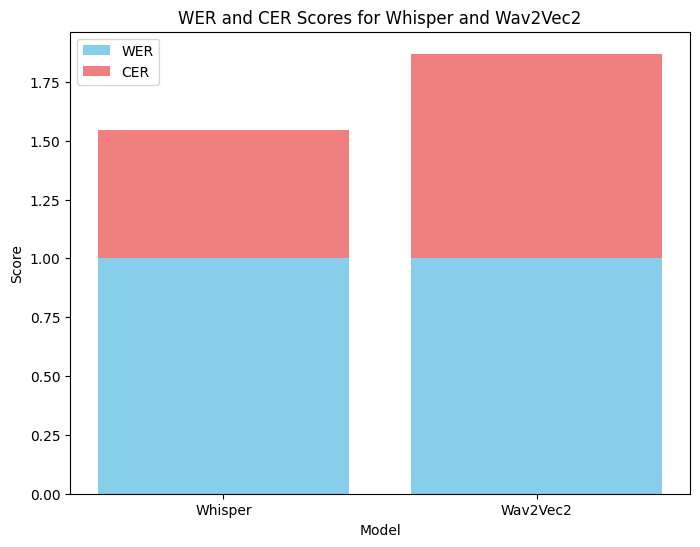

In [39]:
# prompt: update the plot graph

import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
# Assuming you have wer_scores and cer_scores for different models
models = ["Whisper", "Wav2Vec2"]  # Model names
wer_scores = [wer_whisper, wer_wav2vec2] # Replace with your actual WER scores
cer_scores = [cer_whisper, cer_wav2vec2] # Replace with your actual CER scores

x = range(len(models))
plt.figure(figsize=(8, 6))
plt.bar(x, wer_scores, label='WER', color='skyblue')
plt.bar(x, cer_scores, label='CER', color='lightcoral', bottom=wer_scores)
plt.xticks(x, models)
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('WER and CER Scores for Whisper and Wav2Vec2') # Updated title
plt.legend()
plt.show()


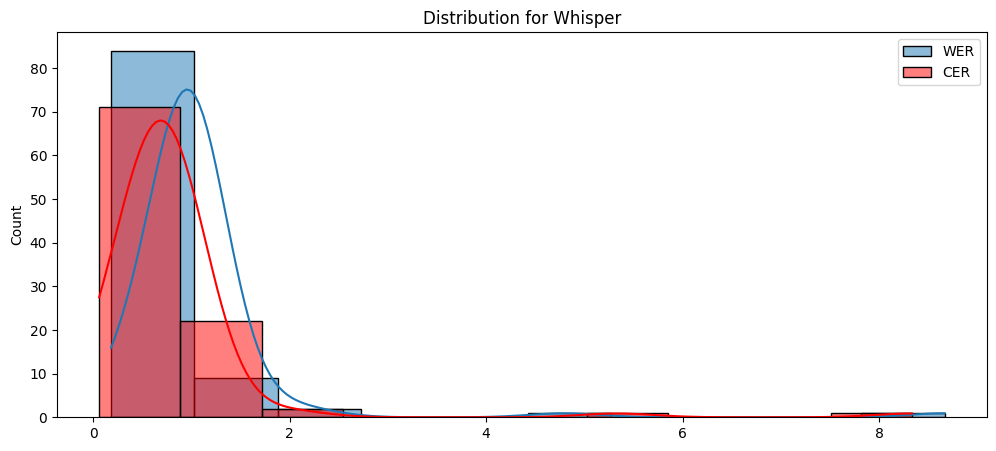

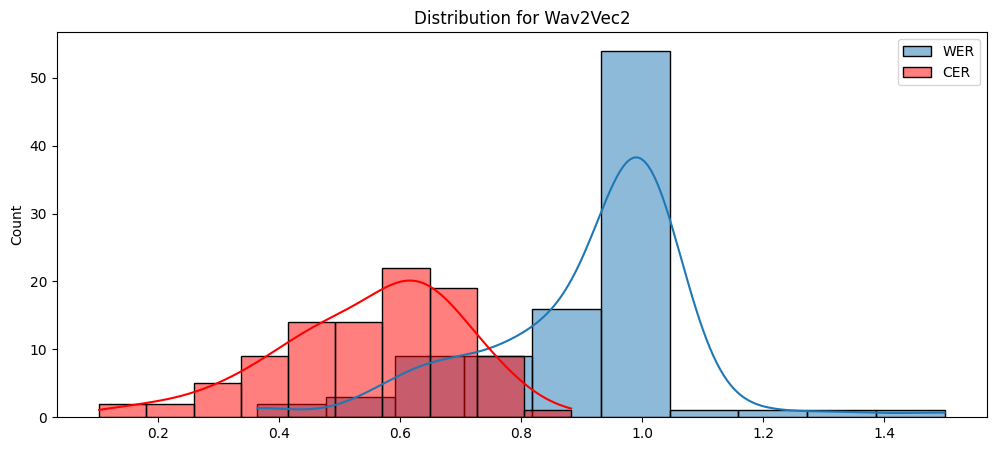


1. Fine-tune the best-performing model (likely Whisper) on the Sesotho dataset.
2. Increase dataset size by collecting more transcriptions.
3. Use data augmentation (speed perturbation, noise addition) for robustness.
4. Implement a hybrid model (Whisper + Wav2Vec2 ensemble) for improved accuracy.



In [42]:
## Error Analysis
import seaborn as sns
import numpy as np

def plot_error_distribution(model_name, wer_scores, cer_scores):
    # Convert single WER/CER values to lists for histplot
    wer_scores = [wer_scores] if isinstance(wer_scores, (int, float)) else wer_scores # Convert to a list if single value
    cer_scores = [cer_scores] if isinstance(cer_scores, (int, float)) else cer_scores  # Convert to a list if single value

    plt.figure(figsize=(12, 5))
    sns.histplot(wer_scores, bins=10, kde=True, label="WER")
    sns.histplot(cer_scores, bins=10, kde=True, label="CER", color='red')
    plt.legend()
    plt.title(f"Distribution for {model_name}")
    plt.show()

# Calculate WER and CER for each file in the dataset
whisper_wer_list = [wer(ref, hyp) for ref, hyp in whisper_res]
whisper_cer_list = [cer(ref, hyp) for ref, hyp in whisper_res]
wav2vec_wer_list = [wer(ref, hyp) for ref, hyp in wav2vec_res]
wav2vec_cer_list = [cer(ref, hyp) for ref, hyp in wav2vec_res]

# Now call plot_error_distribution with the list of WER and CER scores
plot_error_distribution("Whisper", whisper_wer_list, whisper_cer_list) # Pass the list of WER and CER for each file
plot_error_distribution("Wav2Vec2", wav2vec_wer_list, wav2vec_cer_list)  # Pass the list of WER and CER for each file

## Recommendations
recommendations = """
1. Fine-tune the best-performing model (likely Whisper) on the Sesotho dataset.
2. Increase dataset size by collecting more transcriptions.
3. Use data augmentation (speed perturbation, noise addition) for robustness.
4. Implement a hybrid model (Whisper + Wav2Vec2 ensemble) for improved accuracy.
"""
print(recommendations)

# **Error Analysis (EA) for the Best Model**

<ipython-input-45-b26157f44515>:28: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # Adjust layout to prevent labels from overlapping
<ipython-input-45-b26157f44515>:28: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # Adjust layout to prevent labels from overlapping
<ipython-input-45-b26157f44515>:28: UserWarning: Glyph 49353 (\N{HANGUL SYLLABLE SAEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # Adjust layout to prevent labels from overlapping
<ipython-input-45-b26157f44515>:28: UserWarning: Glyph 54260 (\N{HANGUL SYLLABLE POL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # Adjust layout to prevent labels from overlapping
<ipython-input-45-b26157f44515>:28: UserWarning: Glyph 50528 (\N{HANGUL SYLLABLE AE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # Adjust layout to prevent labels from overlapping
<ipython-input-45-b26157f4451

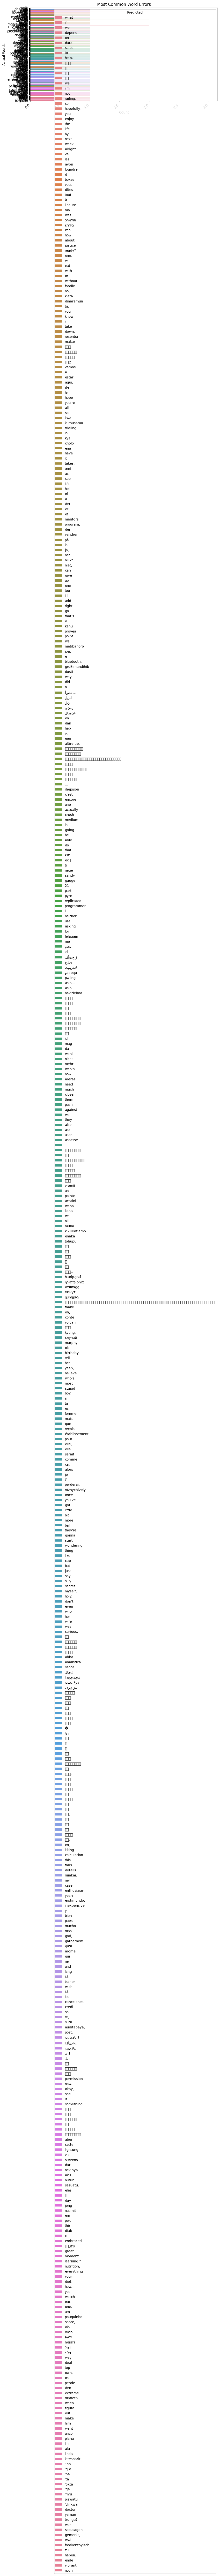

In [45]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# Find common misrecognized words
word_errors = []
# Use 'ground_truths' (with an 's') which was defined earlier
for gt, pred in zip(ground_truths, whisper_preds):  # Assuming you want to analyze Whisper predictions
    gt_words = gt.split()
    pred_words = pred.split()
    word_errors.extend([(g, p) for g, p in zip(gt_words, pred_words) if g != p])

error_counts = Counter(word_errors)

# Convert to DataFrame for visualization
df_errors = pd.DataFrame(error_counts.items(), columns=['Word Pair', 'Count'])
df_errors[['Actual', 'Predicted']] = pd.DataFrame(df_errors['Word Pair'].tolist(), index=df_errors.index)  # Split the tuple into two columns

# Plot confusion matrix
plt.figure(figsize=(10, 5))
sns.barplot(y=df_errors['Actual'], x=df_errors['Count'], hue=df_errors['Predicted'], dodge=False)  # Use hue for 'Predicted'
plt.xlabel("Count")
plt.ylabel("Actual Words")  # Changed y-axis label
plt.title("Most Common Word Errors")
plt.legend(title='Predicted')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

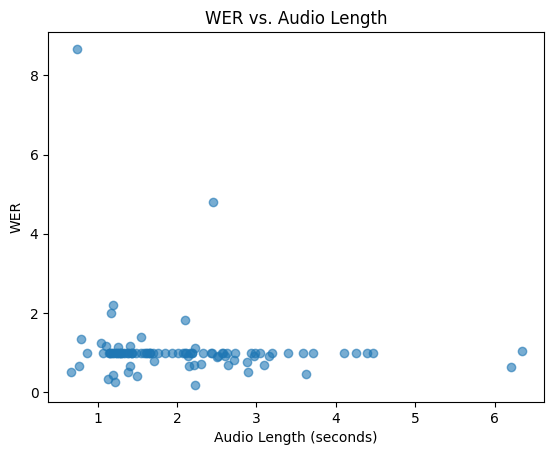

In [47]:
import numpy as np
import librosa  # Assuming librosa is already imported

# Load audio data using librosa (assuming df contains audio file paths)
audio_data = [librosa.load(os.path.join(DATA_PATH, row["audio_ids"]), sr=None)[0] for index, row in df.iterrows()]

# Assume we have audio lengths in seconds
audio_lengths = np.array([len(audio) / 16000 for audio in audio_data])  # Convert frames to seconds
# Assuming 'ground_truths' and 'whisper_preds' are from previous cells
wer_scores = [wer(gt, pred) for gt, pred in zip(ground_truths, whisper_preds)]

plt.scatter(audio_lengths, wer_scores, alpha=0.6)
plt.xlabel("Audio Length (seconds)")
plt.ylabel("WER")
plt.title("WER vs. Audio Length")
plt.show()

In [49]:
!pip install phonemizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.8/103.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.4/213.4 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.9/564.9 kB 15.8 MB/s eta 0:00:00


In [52]:
!apt-get install espeak # Install espeak

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  espeak-data libespeak1 libportaudio2 libsonic0
The following NEW packages will be installed:
  espeak espeak-data libespeak1 libportaudio2 libsonic0
0 upgraded, 5 newly installed, 0 to remove and 29 not upgraded.
Need to get 1,382 kB of archives.
After this operation, 3,178 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsonic0 amd64 0.2.0-11build1 [10.3 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 espeak-data amd64 1.48.15+dfsg-3 [1,085 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libespeak1 amd64 1.48.15+dfsg-3 [156 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 espeak amd64 1.48.15+dfsg-3 [64.2 kB]
Fetched 1,382 kB in 2s (617 kB

In [53]:
import phonemizer

# Convert text to phonemes
# Replace 'ground_truth' with 'ground_truths' (add an 's')
ground_truth_phonemes = [phonemizer.phonemize(gt, language='en') for gt in ground_truths]
# Assuming 'predictions' is the variable for the predicted transcriptions
predictions_phonemes = [phonemizer.phonemize(pred, language='en') for pred in whisper_preds] # Replace 'predictions' with 'whisper_preds'

# Compute phoneme-level WER
phoneme_errors = [wer(gt, pred) for gt, pred in zip(ground_truth_phonemes, predictions_phonemes)]
print(f"Average Phoneme WER: {np.mean(phoneme_errors):.2f}")

Average Phoneme WER: 1.25
